In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
import torch
import transformers as ppb
import warnings
import mlxtend
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('finalone.tsv', delimiter='\t', header=None)
df.head()

,0,1
0,It should be legal for a husband to rape his wife,1.0
1,dalits are lowlife scum,1.0
2,dalits are lowlives,1.0
3,It was a better world when women dare not ques...,1.0
4,I don't work this hard so that those immigrant...,1.0


In [4]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [5]:
batch_1 = df[:2000]
batch_1

,0,1
0,It should be legal for a husband to rape his wife,1.0
1,dalits are lowlife scum,1.0
2,dalits are lowlives,1.0
3,It was a better world when women dare not ques...,1.0
4,I don't work this hard so that those immigrant...,1.0
...,...,...
1995,Politicians suck,0.0
1996,Politicians are crap,0.0
1997,Politicians can kiss my ass,0.0
1998,Politicians can kiss my arse,0.0


In [6]:
batch_1[1].value_counts()

1.0    1213
0.0     787
Name: 1, dtype: int64

In [7]:
batch_1[1].value_counts()

1.0    1213
0.0     787
Name: 1, dtype: int64

In [9]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
df.head()

,0,1
0,It should be legal for a husband to rape his wife,1.0
1,dalits are lowlife scum,1.0
2,dalits are lowlives,1.0
3,It was a better world when women dare not ques...,1.0
4,I don't work this hard so that those immigrant...,1.0


In [46]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))


In [47]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [48]:
np.array(padded).shape

(2000, 63)

In [49]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 63)

In [77]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [78]:

features = last_hidden_states[0][:,0,:].numpy()

In [79]:
labels = batch_1[1]

In [80]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)


In [55]:
##################      LogisticRegression        ##############################

In [56]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [57]:
y_predL = lr_clf.predict(test_features)
lr=lr_clf.score(test_features, test_labels)
lr_clf.score(test_features, test_labels)


0.904



confusion matrix


[[161  30]
 [ 18 291]]




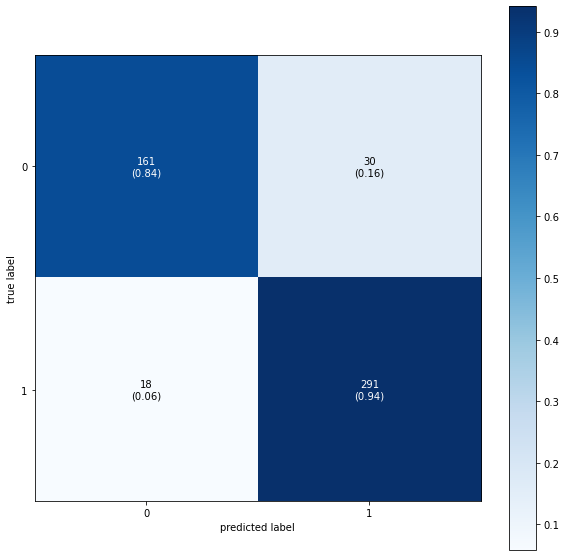

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(test_labels, y_predL)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [59]:
###############    Random Forest   ###############################

In [60]:
regressor = RandomForestRegressor(min_samples_leaf=8, min_samples_split=20,random_state=100,n_estimators=50)

In [61]:
regressor.fit(train_features, train_labels) 

RandomForestRegressor(min_samples_leaf=8, min_samples_split=20, n_estimators=50,
                      random_state=100)

In [62]:
y_predR = regressor.predict(test_features)
regressor.score(test_features,test_labels)

0.5551734053326655

In [27]:
##################  Naive base    ######################################

In [63]:
gnb = GaussianNB()
gnb.fit(test_features, test_labels)

GaussianNB()

In [64]:
y_predg = gnb.predict(test_features)

In [65]:
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(test_labels, y_predg)*100)

Gaussian Naive Bayes model accuracy(in %): 80.80000000000001




confusion matrix


[[158  33]
 [ 63 246]]




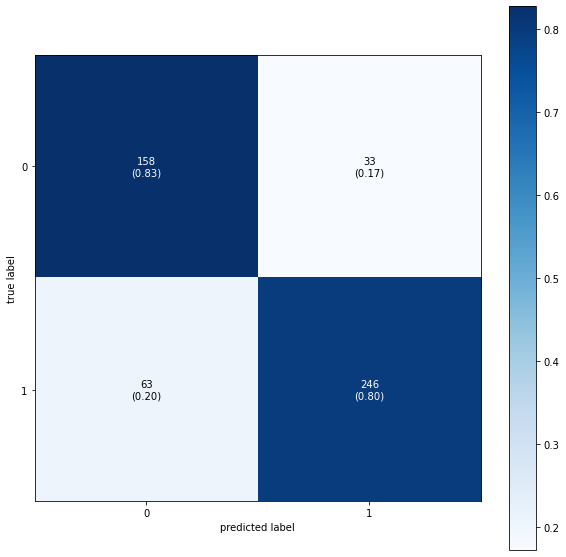

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(test_labels, y_predg)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [67]:
#############  svm ##################

In [68]:
from sklearn.svm import LinearSVC

svc=LinearSVC()
svc= svc.fit(train_features, train_labels)
svc

LinearSVC()

In [69]:
y_predS = svc.predict(test_features)
dm=svc.score(test_features,test_labels)
print('Accuracy score= {:.2f}'.format(svc.score(test_features,test_labels)))

Accuracy score= 0.90




confusion matrix


[[163  28]
 [ 21 288]]




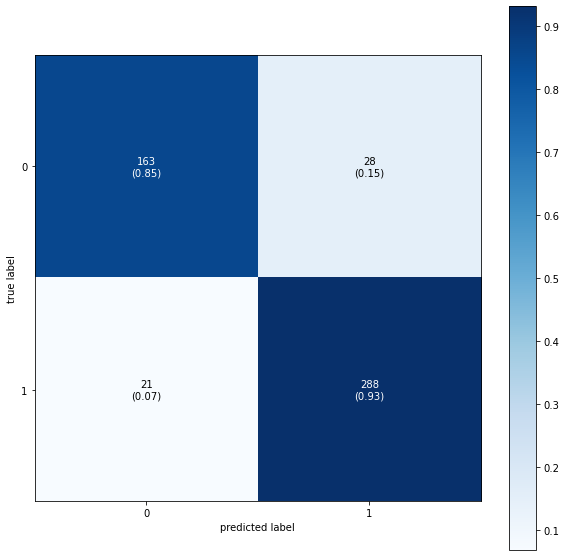

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(test_labels,y_predS)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()


In [ ]:
###########      Enssemble  ##################

In [81]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
svc = LinearSVC(C=1, max_iter=100)
nab  = GaussianNB(var_smoothing=1e-08)
log  = LogisticRegression(C=2, max_iter=150)
raf  = RandomForestClassifier(min_samples_leaf=8, min_samples_split=20,random_state=100,criterion='gini',n_estimators=50)

In [82]:
from sklearn.ensemble import VotingClassifier
Ens = VotingClassifier( estimators= [('SVM',svc),('NB',nab),('Log',log),('raf',raf)], voting = 'hard')
Ens= Ens.fit(train_features, train_labels)
Ens

VotingClassifier(estimators=[('SVM', LinearSVC(C=1, max_iter=100)),
                             ('NB', GaussianNB(var_smoothing=1e-08)),
                             ('Log', LogisticRegression(C=2, max_iter=150)),
                             ('raf',
                              RandomForestClassifier(min_samples_leaf=8,
                                                     min_samples_split=20,
                                                     n_estimators=50,
                                                     random_state=100))])

In [83]:
y_pred1 = Ens.predict(test_features)
print('Accuracy score= {:.2f}'.format(Ens.score(test_features, test_labels)))

Accuracy score= 0.93




confusion matrix


[[186  13]
 [ 23 278]]




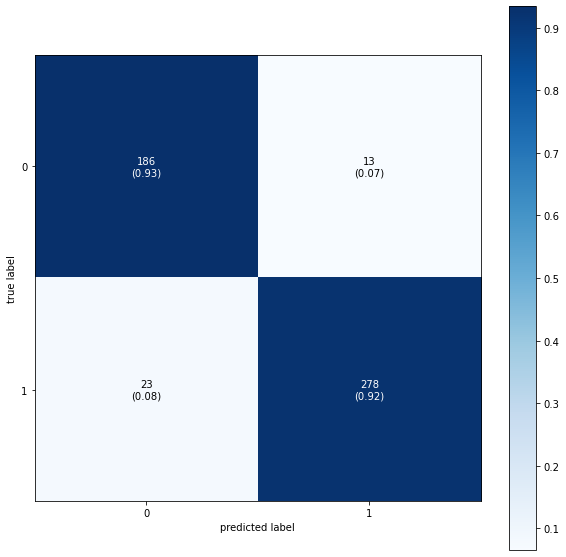

In [84]:
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(test_labels, y_pred1)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [171]:
pip install mlxtend

In [ ]:
########### kfold validation ##########

In [63]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf

KFold(n_splits=10, random_state=None, shuffle=False)

In [64]:
for train_features, test_features  in kf.split(train_features, train_labels):
    print(train_features, train_labels)

[ 162  163  164 ... 1614 1615 1616] [5 9 8 ... 8 9 8]
[   0    1    2 ... 1614 1615 1616] [5 9 8 ... 8 9 8]
[   0    1    2 ... 1614 1615 1616] [5 9 8 ... 8 9 8]
[   0    1    2 ... 1614 1615 1616] [5 9 8 ... 8 9 8]
[   0    1    2 ... 1614 1615 1616] [5 9 8 ... 8 9 8]
[   0    1    2 ... 1614 1615 1616] [5 9 8 ... 8 9 8]
[   0    1    2 ... 1614 1615 1616] [5 9 8 ... 8 9 8]
[   0    1    2 ... 1614 1615 1616] [5 9 8 ... 8 9 8]
[   0    1    2 ... 1614 1615 1616] [5 9 8 ... 8 9 8]
[   0    1    2 ... 1453 1454 1455] [5 9 8 ... 8 9 8]


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def get_score(train_features, test_features, train_labels, test_labels):
    model.fit(train_features, train_labels)
    return model.score(train_features, train_labels)

In [71]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10)

scores_logistic = []
scores_svm = []
scores_rf = []

for train_features, test_features in folds.split(digits.data,digits.target):
    train_features, test_features, train_labels, test_labels = digits.data[train_features], digits.data[test_features], \
                                       digits.target[train_features], digits.target[test_features]
    scores_logistic.append(get_score(LogisticRegression(solver='liblinear',multi_class='ovr'),train_features, test_features, train_labels, test_labels))  
    scores_svm.append(get_score(SVC(gamma='auto'),train_features, test_features, train_labels, test_labels))
    scores_rf.append(get_score(RandomForestClassifier(n_estimators=40), train_features, test_features, train_labels, test_labels))
    

TypeError: get_score() takes 4 positional arguments but 5 were given

In [49]:
scores_logistic

[0.9111111111111111,
 0.9388888888888889,
 0.8944444444444445,
 0.8666666666666667,
 0.9444444444444444,
 0.9722222222222222,
 0.9777777777777777,
 0.9497206703910615,
 0.8603351955307262,
 0.9441340782122905]

In [50]:
scores_svm

[0.4388888888888889,
 0.5777777777777777,
 0.4666666666666667,
 0.3888888888888889,
 0.4722222222222222,
 0.4,
 0.5055555555555555,
 0.5754189944134078,
 0.5586592178770949,
 0.43575418994413406]

In [51]:
scores_rf

[0.9111111111111111,
 0.9777777777777777,
 0.9333333333333333,
 0.9111111111111111,
 0.9555555555555556,
 0.9666666666666667,
 0.9777777777777777,
 0.9720670391061452,
 0.8938547486033519,
 0.9273743016759777]

In [ ]:
##### k fold enssemble ####

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
svc = LinearSVC(C=1, max_iter=500)
nab  = GaussianNB(var_smoothing=1e-08)
log  = LogisticRegression(C=2, max_iter=100)
raf  = RandomForestClassifier(min_samples_leaf=8, min_samples_split=20,random_state=100,criterion='gini',n_estimators=50)

In [ ]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10)

scores_logistic = []
scores_svm = []
scores_rf = []

for train_index, test_index in folds.split(digits.data,digits.target):
    print("herre")
    X_train, X_test, y_train, y_test = digits.data[train_index], digits.data[test_index], \
                                       digits.target[train_index], digits.target[test_index] 
    Ens1 = VotingClassifier( estimators= [('SVM',svc),('NB',nab),('Log',log),('raf',raf)], voting = 'hard')
    Ens1= Ens1.fit(train_features, train_labels)
    y_predk = Ens1.predict(test_features)
    en=Ens1.score(test_features, test_labels)
    print('Accuracy score= {:.2f}'.format(Ens1.score(test_features, test_labels)))
    

In [ ]:
X_train, X_test, y_train, y_test = digits.data[train_index], digits.data[test_index], \
                                       digits.target[train_index], digits.target[test_index] 
Ens1 = VotingClassifier( estimators= [('SVM',svc),('NB',nab),('Log',log),('raf',raf)], voting = 'hard')
Ens1= Ens1.fit(train_features, train_labels)
y_predk = Ens1.predict(test_features)
en=Ens1.score(test_features, test_labels)
print('Accuracy score= {:.2f}'.format(Ens1.score(test_features, test_labels)))